#**Binary Classification of GAN-generated High-Resolution Images via Convolutional Neural Networks** <br> 
## Alice Schiavone, Università degli Studi di Milano <br> <br>

Total run time: ~25m

Upload your $Kaggle.json$ file. (Your profile > Account > Create New API Token) <br> Needed to download dataset from Kaggle.

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alices9","key":"c88ec4ad4679fed3ee464e0be8760abf"}'}

# Environment set up 

* Install libraries
* Set distribuited computation system
* Change Google Colab work environment



In [2]:
%%capture
!pip install kaggle
!pip install keras-tuner
 # generic / environment 
import numpy as np
import pandas as pd
import os
import json
 # data exploration / preprocessing
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
import io

 # model 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D # layers
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, Input, GlobalMaxPooling2D, BatchNormalization # layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint # callbacks
from tensorflow.keras.layers.experimental import preprocessing
import keras_tuner as kt # tuning
from kerastuner.tuners import Hyperband

In [3]:
distribution = tf.distribute.MirroredStrategy()
print ('GPU is available? {}'.format(tf.test.is_gpu_available()), '- Number of devices: {}'.format(distribution.num_replicas_in_sync)) # test

GPU is available? True - Number of devices: 1


In [4]:
!mkdir -p ~/.kaggle/ && mkdir ~/dataset/ 
!mv kaggle.json ~/.kaggle/ 
!chmod 600 ~/.kaggle/kaggle.json

* Download dataset. Estimated time: ~5m

In [5]:
%%capture
# discard output
!kaggle datasets download -d jeffheaton/glasses-or-no-glasses -p ~/dataset/ 
%cd ~/dataset
!unzip \*.zip  && rm *.zip

In [6]:
DATA_PATH = '/root/dataset'
IMG_PATH = '/root/dataset/faces-spring-2020/faces-spring-2020/'
SEED = 2021

# Data exploration and pre-processing

In [7]:
BATCH_SIZE = 32
TARGET_SIZE = (32,32) # img resolution
RESIZE_FACTOR = 5 # Use 4 to have 64x64 images

## Initial data set preparation

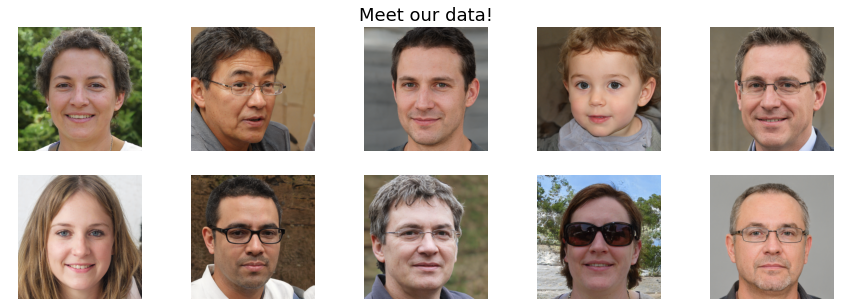

In [8]:
fig=plt.figure(figsize=(15, 5))
plt.title('Meet our data!', loc='center', fontdict={'fontsize':18})
plt.axis('off')
columns = 5
rows = 2
for i in range(0, 10):
    pic_name = IMG_PATH + os.listdir(IMG_PATH)[i+1]
    img=plt.imread(pic_name)
    fig.add_subplot(rows, columns, i+1)

    plt.imshow(img)
    plt.axis('off')
plt.show()

In [9]:
label_path = DATA_PATH + '/train.csv'
labels = pd.read_csv(label_path, usecols=['id','glasses'], index_col='id', dtype={'glasses':str})

img_df = labels.copy()
img_df['name'] = ''
filenames = sorted(int(x[5:-4]) for x in os.listdir(IMG_PATH))

for p in range(len(img_df)):
    img_df.at[p+1, 'name'] = 'face-' + str(filenames[p]) + '.png'
    
img_df['glasses'] = img_df['glasses'].astype(str)

img_df.head()

glasses        name
id                    
1        0  face-1.png
2        1  face-2.png
3        1  face-3.png
4        0  face-4.png
5        0  face-5.png

In [10]:
face = Image.open(IMG_PATH + img_df['name'][1])
print('Image dimensions: width, height = {}'.format(face.size) + ', channels = {}'.format(len(face.getbands())))
IMAGE_SIZE = face.size

Image dimensions: width, height = (1024, 1024), channels = 3


In [11]:
img_df['glasses'].value_counts(normalize=True) # minority class takes large portion of the data set, model will not ignore it

1    0.634667
0    0.365333
Name: glasses, dtype: float64

In [12]:
train_df, valid_df = train_test_split(
    img_df[:4000], test_size=0.20, random_state = SEED ) # use 4000 images to train (80%) and validate (20%), 500 to evaluate.

In [13]:
N_TRAIN = train_df.shape[0]
N_VALID = valid_df.shape[0]
BATCH_SIZE_PER_REPLICA = int(BATCH_SIZE / distribution.num_replicas_in_sync)
COLOR_MODE = 'rgb'
CHANNELS = len(face.getbands())
N_CLASSES = 2
KERNEL_SIZE = (3,3)

## See possible image transformations. Could they be useful? 

Found 1 validated image filenames belonging to 1 classes.


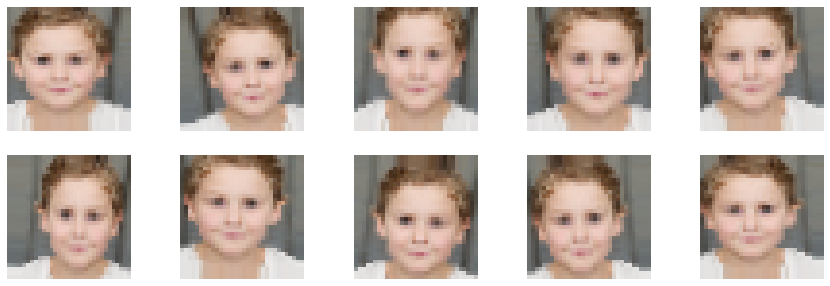

In [14]:
example_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=5,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

example = example_datagen.flow_from_dataframe(
    dataframe = valid_df.sample(n=1), # sample one img to show transformations
    directory = IMG_PATH,
    x_col = "name", 
    y_col = "glasses", 
    class_mode = "categorical",
    target_size = TARGET_SIZE,
    batch_size = BATCH_SIZE,
    color_mode = COLOR_MODE,
    seed=SEED
)

plt.figure(figsize=(15, 5))
columns = 5
rows = 2
for i in range(0, 10):
    plt.subplot(rows, columns, i+1)
    for X_batch, Y_batch in example:
        image = X_batch[0]
        plt.imshow(image)
        plt.axis('off')
        break
plt.show()

## Building the data set: how to feed the model efficiently?

Make a dataset out of the raw images.

In [15]:
def build_data_sets(data_set):
  # Let ImageDataGenerator handle only the pixel value rescaling, flow_from_dataframe the resizing to the target value. 
  # This way it would not be required to divide images into folders, but classes will be validated automatically.
  datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    rescale = 1./255
  )

  ds = tf.data.Dataset.from_generator(
      # Takes the dataframe and the path to a directory + generates batches. The generated batches contain augmented/normalized data.
      lambda: datagen.flow_from_dataframe( 
        dataframe = data_set, # validation set
        directory = IMG_PATH,
        x_col = "name", 
        y_col = "glasses", 
        class_mode = "binary",
        target_size = TARGET_SIZE,
        batch_size = BATCH_SIZE_PER_REPLICA,
        color_mode = COLOR_MODE,
        seed = SEED,
        shuffle = True
    ),
      output_types=(tf.float32, tf.float32), 
      output_shapes=([None, TARGET_SIZE[0], TARGET_SIZE[0], CHANNELS], [None, ])
  )

  return ds.cache().prefetch(tf.data.AUTOTUNE)

#distributed_train_set = build_data_sets(train_df)
#distributed_valid_set = build_data_sets(valid_df)

This method works, but is not scalable. Citing TensorFlow [doc](https://www.tensorflow.org/guide/data#consuming_python_generators): <br> _'While this is a convienient approach it has limited portability and scalibility. It must run in the same python process that created the generator, and is still subject to the Python GIL.'_

Instead, we will build a binary streaming input pipeline with the TFRecord data format, because data I/O is the main bottleneck of this classification problem, given that it would not fit in main memory. We also resize the images before storing them as TFRecords. 

||No resizing|After resizing (dividing both dimensions by $2^4$)| ... and by $2^5$ |
| --- | --- | -- | -- | 
|Number of records per chunk|450|
|Chunk size|564MB|3.6MB|1.1MB|

Using TFRecords and images of 32x32 pixels, we reduce the storing requirements by more than 150%. Plus, we are able to send chunks of records through out the distributed system. 

In [16]:
record_filename = 'record_chunk_#{}.tfrecords'
N_SPLITS = 10   # Number of chunks
counter = 1     # Scan the dataframe
TARGET_SIZE = tuple(dimension//2**RESIZE_FACTOR for dimension in IMAGE_SIZE)

#def bytes_feature(value): ##### GUARDA SE PUOI CANCELLAREEEE
#    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def image_serialization(image, label):
  global counter
  features = {
      'image' : tf.train.Feature(bytes_list=tf.train.BytesList(value=[image])),
      'label' : tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
      'name' : tf.train.Feature(int64_list=tf.train.Int64List(value=[counter])), # img number
  }
  return tf.train.Example(features = tf.train.Features(feature=features))

def resize_img(resize_factor = 0): # doesn't resize
  global counter
  with Image.open(IMG_PATH + img_df.loc[counter]['name']) as img:
    resized_img = img.resize((img.width // 2**resize_factor , img.height // 2**resize_factor)) 
  img_byte = io.BytesIO()
  resized_img.save(img_byte, format='PNG')
  return img_byte.getvalue()

def serialize_image(): # image generator
  global counter
  for i in range(int(len(img_df)/N_SPLITS)): # divide equally the number of images in chunks
    image_string = resize_img(resize_factor=RESIZE_FACTOR) # open image while resizing
    label = int(img_df.loc[counter]['glasses'])
    tf_example = image_serialization(image_string, label)
    counter +=1
    yield tf_example.SerializeToString()

def data_set_generator():
  ds = tf.data.Dataset.from_generator(
      serialize_image, # generator
      output_types=tf.string, 
      output_shapes=()
  )
  return ds

  # Chunks should be of ~100MB, and of at least 10MB to benefit from this implementation.
  # Given the limited number of images, we are ok with far smaller chunks, just to show 
  # how it works with multiple chunks.

for index in range(N_SPLITS): 
    writer = tf.data.experimental.TFRecordWriter(record_filename.format(index))
    serialized_features_dataset = data_set_generator()
    writer.write(serialized_features_dataset)

In [17]:
# test the number of records per chunk and its size
data_set = tf.data.TFRecordDataset('record_chunk_#0.tfrecords')
records_n = sum(1 for record in data_set)

print("records_n = {}".format(records_n))
!du -sh 'record_chunk_#0.tfrecords'

records_n = 450
1.1M	record_chunk_#0.tfrecords


In [18]:
# print one record and its structure
for raw_record in data_set.take(1):
  example = tf.train.Example()
  example.ParseFromString(raw_record.numpy())
  print(example)

features {
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\211PNG\r\n\032\n\000\000\000\rIHDR\000\000\000 \000\000\000 \010\002\000\000\000\374\030\355\243\000\000\010\270IDATx\234UV[s\224\307\021\355\356\231\371\256{\325\256.\210\225\004\002!\004\266\203q\210\313\216\313N\250\270\362\230\207\374\224\374&W\036r\251\244\\\345\227\270\3121\t\266\003\266\t\306\025C\000Y t\227v\245\335\375\356\323\323yX\300N\317\303\364\313\364\251\3569\335\247\361O\177\371+\000\210\210\210   &\243\223\377|s\347\346\215\033\333;\273D\030\372\246\252*\021A\200\242d\026\t|s\356\374\371w\257\377j\351\3549\'\340\373\276\023\261l\2652\210\360c\023\001=y\t\" b\271zp\357\316\335\333\237\357\354\356\017\223\274Y\217\2151i\232\216\222\314Zf\021Ok\245T\222\025\367\276\27178<|\347\027\327\027\317\255\364\026\026\235\265\010\200 \000\377\207\200\210\032\021\304\t\0219\266_\337\374\373\335[\237\355\036\035\217\323\242\026\307\204`\213\234\231E\240\262\214\210D*+JD4J\035\034\366\377\366\321\

## Read data
This part is deeply inspired by Amy MiHyun Jang's [tutorial](https://keras.io/examples/keras_recipes/tfrecord/) on the Keras documentation website.

In [19]:
RECORDS_LIST = sorted(tf.io.gfile.glob('record_chunk_#*.tfrecords'))
split_factor = int(0.6 * len(RECORDS_LIST)) #Use 60% to train, 30% to validate, 10% to test
split_factor_test = int(0.9 * len(RECORDS_LIST))
TRAIN_RECORDS, VALID_RECORDS, TEST_RECORDS = RECORDS_LIST[:split_factor], RECORDS_LIST[split_factor:split_factor_test], RECORDS_LIST[split_factor_test:]
print('# of tfrecords files for training: ' + str(len(TRAIN_RECORDS)),
      ', # of tfrecords files for validation: ' + str(len(VALID_RECORDS)),
      ', tfrecords files used for testing: ' + str(TEST_RECORDS))

# of tfrecords files for training: 6 , # of tfrecords files for validation: 3 , tfrecords files used for testing: ['./record_chunk_#9.tfrecords']


In [20]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image, TARGET_SIZE+(CHANNELS,))
    return image

def read_tfrecord(example):
  image_feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'name' : tf.io.FixedLenFeature([], tf.int64)
    }
  example = tf.io.parse_single_example(example, image_feature_description)
  image = decode_image(example["image"])
  label = tf.cast(example["label"], tf.int64)
  name = tf.cast(example["name"], tf.int64)
  return image, label, name

def load_dataset(filenames):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # use data as soon as it comes in, disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames)  # automatically interleaves reads from multiple files
    #dataset = dataset.with_options(ignore_order) # use when order doesn't matter
    dataset = dataset.map(
        read_tfrecord, num_parallel_calls=AUTOTUNE
    )
    return dataset

def get_dataset(filenames, is_train, batch_size=BATCH_SIZE):
    dataset = load_dataset(filenames)
    if is_train:
      dataset = dataset.shuffle(SEED)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.batch(batch_size)
    return dataset

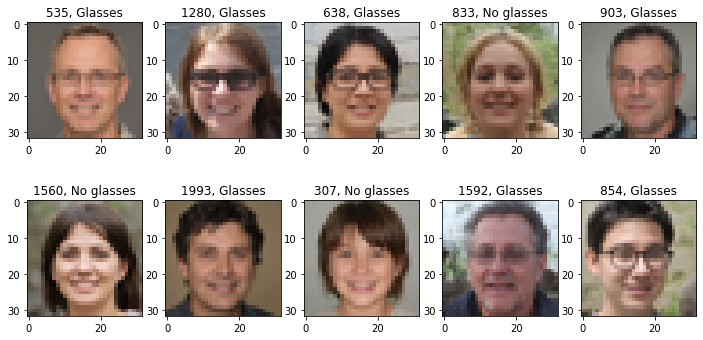

In [21]:
train_dataset = get_dataset(TRAIN_RECORDS, True)
valid_dataset = get_dataset(VALID_RECORDS, True)
test_dataset = get_dataset(TEST_RECORDS, False, batch_size=records_n)

image_batch, label_batch, name_batch = next(iter(train_dataset))

def show_batch(image_batch, label_batch, name_batch):
  plt.figure(figsize=(12, 6))
  for n in range(10):
    ax = plt.subplot(2, 5, n + 1)
    plt.imshow(image_batch[n] / 255.0)
    if label_batch[n]:
      plt.title(str(name_batch[n])+', Glasses')
    else:
      plt.title(str(name_batch[n])+', No glasses')
    #plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy(), name_batch.numpy())

Everything is fine (notice the images' axes dimensions). Time to train the model.

# Train the model
Let's start the training with a standard architecture.

In [22]:
initial_learning_rate = 0.002
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10, decay_rate=0.96, staircase=True
)

def make_model(kernel_size = (3,3)):
  model = Sequential()
  model.add(Input(shape = TARGET_SIZE + (CHANNELS,) ))

  model.add(Conv2D(16, kernel_size, activation = 'relu', padding="same"))
  model.add(Conv2D(16, kernel_size, activation = 'relu', padding="same"))
  model.add(MaxPooling2D())
  model.add(BatchNormalization())

  model.add(Conv2D(64, kernel_size, activation = 'relu', padding="same"))
  model.add(Conv2D(64, kernel_size, activation = 'relu', padding="same"))
  model.add(MaxPooling2D())
  model.add(BatchNormalization())
  
  model.add(Conv2D(128, kernel_size, activation = 'relu', padding="same"))
  model.add(Conv2D(128, kernel_size, activation = 'relu', padding="same"))
  model.add(GlobalMaxPooling2D())
  model.add(BatchNormalization())
  
  model.add(Dense(16, activation = 'relu'))
  model.add(Dropout(0.2))
        
  model.add(Dense(1, activation = "sigmoid"))

  model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss="binary_crossentropy", #log loss
        metrics='accuracy'
    )
  return model

We will not use the EarlyStopping callback to see how many epochs are required to get a good result. 
* Uncomment the line 'callbacks' to save time (3/4m)

In [23]:
%%capture
epochs = 100
CALLBACKS = tf.keras.callbacks.EarlyStopping(
          monitor='val_loss', patience=10, 
          restore_best_weights = True
          )

with distribution.scope():
  model = make_model()

  history = model.fit(
      train_dataset,
      validation_data=valid_dataset,
      epochs=epochs,
      #callbacks = CALLBACKS,
      verbose=2
  )

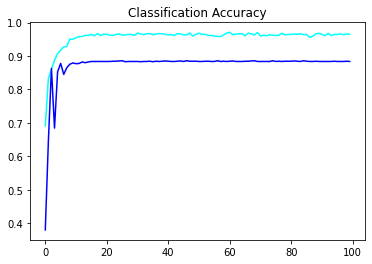

In [24]:
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='cyan', label='training')
plt.plot(history.history['val_accuracy'], color='blue', label='validation')

Even if the model reaches 1.00 accuracy, it overfits a lot. The validation set accuracy doesn't improve at all after about 30 epochs. The good thing is that we can stop the training pretty soon. This will reveal useful when searching the right hyperparameters, even if it could totally happen that a model that perform badly in the first epochs, 'wakes up' after a lot of time.

We train the model again with 30 epochs so that it can be compared to the others.

In [25]:
%%capture
epochs = 30
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=epochs,
    verbose=2
)

# Hyperparameter search
To scout easily for the best hyperparameters, we use [KerasTuner](https://keras.io/keras_tuner/). This implementation is also scalable because, citing the documentation: <br> _'KerasTuner also supports data parallelism via tf.distribute. [...] You can run (multiple) parallel trials with each trial training on (multiple) GPUs by using tf.distribute.MirroredStrategy.'_ <br> <br>
Because Google Colab doesn't have enough resources to keep up with the training of many possible different combinations, we stick with only 5 trials and 30 epochs.
<br> <br>
The model will still train on accuracy, but the Tuner will focus on getting the best result on the validation accuracy, that stops improving in the previous model. 

In [26]:
epochs = 30
max_trials = 5

def build_tuning_model(hp):
  model = Sequential()
  model.add(Input(shape = TARGET_SIZE + (CHANNELS,) ))

  # Convolutional body
  for i in range(hp.Int('convolutional_layers', min_value=1, max_value=4,
                        step=1, default=2)):
    
    choice_kernel_size = hp.Int('kernel_size', min_value=3, max_value=5,
                        step=2, default=3)

    model.add(Conv2D(
        filters = hp.Int('filters_A_' + str(i), min_value=4, max_value=64,
                        step=16, default=32), 
        kernel_size = (choice_kernel_size, choice_kernel_size),
        activation = 'relu', padding="same")
    )
    model.add(Conv2D(
        filters = hp.Int('filters_B_' + str(i), min_value=4, max_value=64,
                        step=16, default=32), 
        kernel_size = (choice_kernel_size, choice_kernel_size),
        activation = 'relu', padding="same")
    )

    choice_pooling = hp.Choice('pooling' + str(i), ['max', 'avg', 'none'])
    if choice_pooling == 'max':
      model.add(MaxPooling2D())
    elif choice_pooling == 'avg':
      model.add(AveragePooling2D())
    else:
      continue
    model.add(BatchNormalization())

  # Global pooling
  if hp.Choice('global-pooling', ['max', 'avg']) == 'max':
    model.add(GlobalMaxPooling2D())
  else:
    model.add(GlobalAveragePooling2D())

  # Out layers
  for i in range(hp.Int('dense_dropout_layers', min_value=1, max_value=5,
                        step=1, default=2)):    
    model.add(Dense( hp.Int('dense_' + str(i), min_value=8, max_value=128,
            step=8, default=8),
      activation = "relu"))
    model.add( Dropout( hp.Float('dropout_' + str(i), min_value=0.1, max_value=0.5,
            step=0.1, default=0.2)
    ))
        
  model.add(Dense(1, activation = "sigmoid"))

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
      loss="binary_crossentropy",
      metrics='accuracy'
    )
  return model

def tune_model():
  tuner = kt.RandomSearch(
    hypermodel=build_tuning_model,
    objective="val_accuracy",
    max_trials=max_trials
  )

  tuner.search(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    #callbacks=[CALLBACKS]
  )
  print(tuner.results_summary(1))
  return tuner.get_best_models(num_models=5)


tuned_model = tune_model()[0]
tuned_history = tuned_model.fit(
      train_dataset,
      epochs=epochs,
      validation_data=valid_dataset
)

Trial 5 Complete [00h 01m 10s]
val_accuracy: 0.855555534362793

Best val_accuracy So Far: 0.8748148083686829
Total elapsed time: 00h 06m 01s
Results summary
Results in ./untitled_project
Showing 1 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
convolutional_layers: 3
kernel_size: 5
filters_A_0: 20
filters_B_0: 20
pooling0: max
filters_A_1: 52
filters_B_1: 52
pooling1: avg
global-pooling: avg
dense_dropout_layers: 1
dense_0: 72
dropout_0: 0.4
dense_1: 24
dropout_1: 0.30000000000000004
filters_A_2: 32
filters_B_2: 32
pooling2: max
Score: 0.8748148083686829
None
Epoch 1/30
85/85 [==============================] - 3s 25ms/step - loss: 263.8339 - accuracy: 0.9170 - val_loss: 1010.5278 - val_accuracy: 0.8719
Epoch 2/30
85/85 [==============================] - 2s 20ms/step - loss: 264.0982 - accuracy: 0.9163 - val_loss: 991.9482 - val_accuracy: 0.8726
Epoch 3/30
85/85 [==============================] - 2s 20ms/step - loss: 249.7205 - accuracy: 0.920

Let's try with tuning the learning rate.

In [27]:
epochs = 30
max_trials = 5

def build_tuning_model_LR(hp):
  initial_learning_rate = hp.Float('initial_learning_rate', min_value=0.001, max_value=0.1,
            step=0.0005, default=0.002)
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate, decay_steps= hp.Int('decay_steps', min_value=1, max_value=20, step=2, default=10), 
      decay_rate= hp.Float('decay_rate', min_value=0.01, max_value=0.99, step=0.05, default=0.95), 
      staircase=True
  )
  make_model() # re use initial model

tuned_model_LR = tune_model()[0]
tuned_history_LR = tuned_model.fit(
      train_dataset,
      epochs=epochs,
      validation_data=valid_dataset,
      #callbacks=CALLBACKS
)

Results summary
Results in ./untitled_project
Showing 1 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
convolutional_layers: 3
kernel_size: 5
filters_A_0: 20
filters_B_0: 20
pooling0: max
filters_A_1: 52
filters_B_1: 52
pooling1: avg
global-pooling: avg
dense_dropout_layers: 1
dense_0: 72
dropout_0: 0.4
dense_1: 24
dropout_1: 0.30000000000000004
filters_A_2: 32
filters_B_2: 32
pooling2: max
Score: 0.8748148083686829
None
Epoch 1/30
85/85 [==============================] - 2s 22ms/step - loss: 231.5668 - accuracy: 0.9278 - val_loss: 1016.7198 - val_accuracy: 0.8652
Epoch 2/30
85/85 [==============================] - 2s 20ms/step - loss: 225.9319 - accuracy: 0.9278 - val_loss: 1017.6107 - val_accuracy: 0.8659
Epoch 3/30
85/85 [==============================] - 2s 20ms/step - loss: 229.1061 - accuracy: 0.9256 - val_loss: 1018.0511 - val_accuracy: 0.8674
Epoch 4/30
85/85 [==============================] - 2s 20ms/step - loss: 232.4140 - accuracy:

# Model evaluation

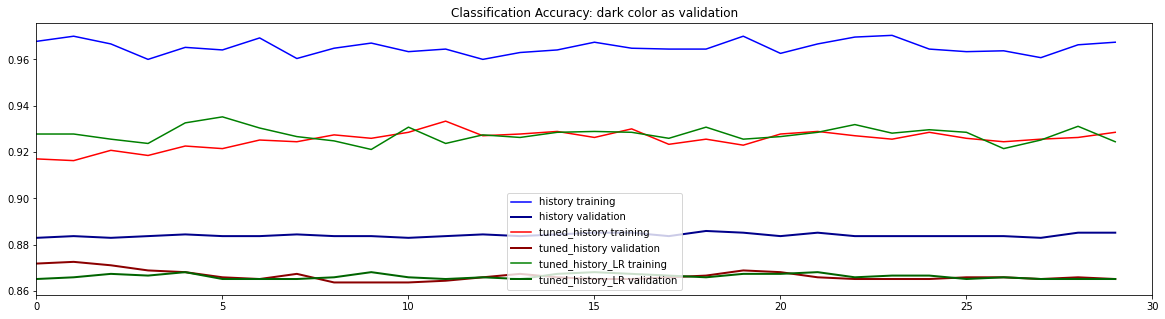

In [28]:
plt.figure(figsize=(20, 5))
plt.title('Classification Accuracy: dark color as validation')
plt.plot(history.history['accuracy'], color='blue', label='history training')
plt.plot(history.history['val_accuracy'], color='darkblue', label='history validation', linewidth=2)
plt.plot(tuned_history.history['accuracy'], color='red', label='tuned_history training')
plt.plot(tuned_history.history['val_accuracy'], color='darkred', label='tuned_history validation', linewidth=2)
plt.plot(tuned_history_LR.history['accuracy'], color='green', label='tuned_history_LR training')
plt.plot(tuned_history_LR.history['val_accuracy'], color='darkgreen', label='tuned_history_LR validation', linewidth=2)
plt.xlim([0,30])

plt.legend(['history training', 'history validation', 'tuned_history training', 'tuned_history validation', 'tuned_history_LR training', 'tuned_history_LR validation'],loc=8)

In [29]:
model.evaluate(test_dataset, batch_size=records_n)
tuned_model.evaluate(test_dataset, batch_size=records_n)
tuned_model_LR.evaluate(test_dataset, batch_size=records_n)

1/1 [==============================] - 0s 482ms/step - loss: 1193.4454 - accuracy: 0.8778


[1193.4454345703125, 0.8777777552604675]

## Visual evaluation method based on logistic loss
If we assume a dumb cross entropy classifier, we get that $-np.log(0.5) =  0. 693$. <br> This means that if we want to say that a correct classification needs to be above a 0.95 threshold, we will light up as correct all the losses that are equal or less than $-np.log(0.95) =  0.05$.

The darker the plot is, the lower is the error.
Base model


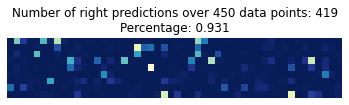

Tuned model


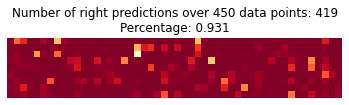

Tuned LR model


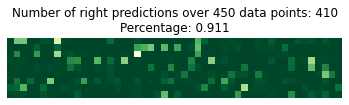

In [30]:
def cross_entropy_loss(true_labels, predictions):
  ce_result = []
  for i in range(len(true_labels)):
    if i == 1: # we get high values for bad predictions and low values (close to 0) for good predictions
      ce_result.append( -np.log(predictions[i]) )
    else:
      ce_result.append( -np.log(1 - predictions[i]) )
  return np.array(ce_result)

true_labels = np.array(img_df['glasses'][-records_n:].astype(int)) 

def prediction_colors(model, cmap='binary', threshold=0.5):
  predictions = model.predict(test_dataset, batch_size=records_n)
  predictions_loss = np.squeeze(predictions)
  loss = true_labels * (-np.log(predictions_loss)) + (1 - true_labels) * (-np.log(1 - predictions_loss)) 
  '''
  plt.ylim(0,0.2)
  plt.plot(range(0,450), loss, 'ro')
  plt.show()
  '''
  #loss[loss >= threshold] = 1 
  #loss[loss < threshold] = 0
  
  plt.imshow(np.split(loss,len(loss)//50), cmap=cmap)
  plt.axis('off')
  plt.title('Number of right predictions over {}'.format(len(loss))+' data points: {}'.format( (loss <= threshold).sum() )+
            '\nPercentage: {}'.format(round(((loss <= threshold).sum() / len(loss) ), 3 )))
  plt.show()
  
# np.count_nonzero(loss)
print('The darker the plot is, the lower is the error.')
print('Base model')
prediction_colors(model,'YlGnBu_r',threshold=0.95)
print('Tuned model')
prediction_colors(tuned_model, 'YlOrRd_r',threshold=0.95)
print('Tuned LR model')
prediction_colors(tuned_model_LR, 'YlGn_r',threshold=0.95)

Finally, let's print the best model predictions of the test set for a handful of images. The number in brackets represents the probability of being _bespectacled_. <br>We put in a list all the predictions that are around $0.5$, and print out a set of 5 images that include that one.
>close to 0 = no glasses, close to 1 = glasses 


In [32]:
predictions = model.predict(test_dataset, batch_size=records_n)

uncertain = []
for i in range(len(predictions)):
  if 0.4 < predictions[i] < 0.6 :
    uncertain.append(i)
uncertain

[2, 160, 194, 227, 245, 315, 323, 352, 385, 410, 425, 445, 446]

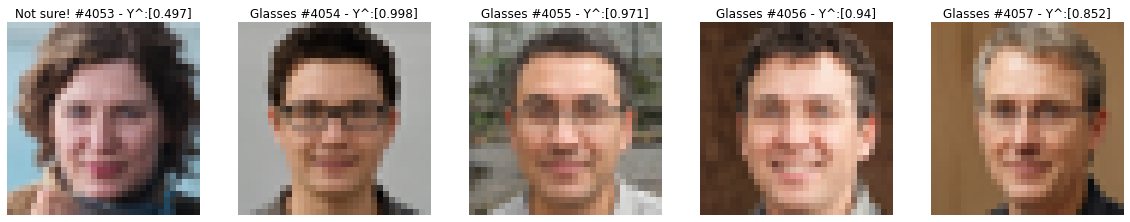

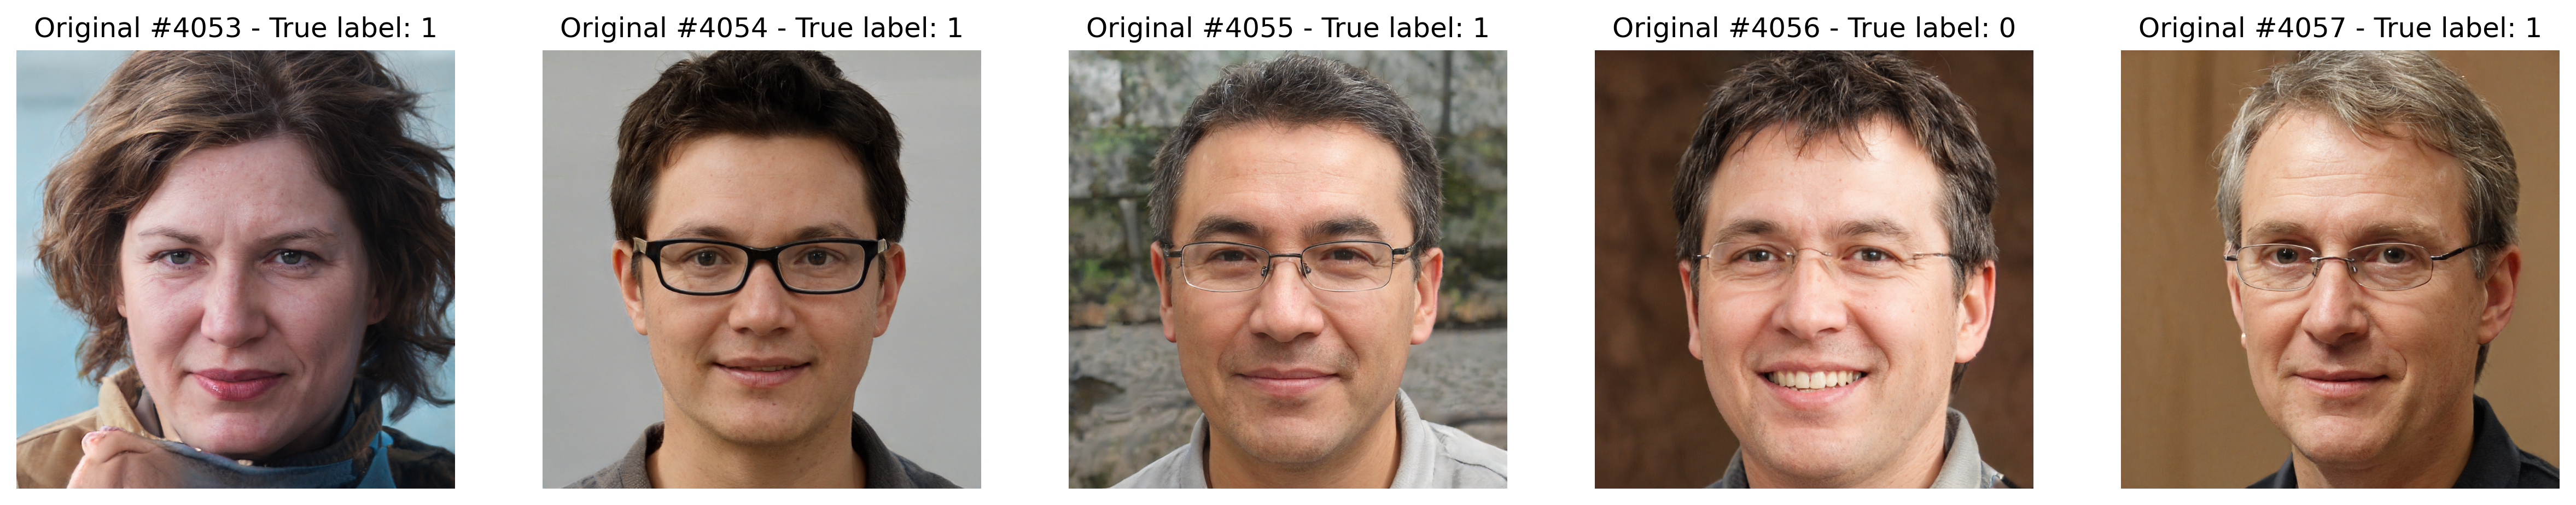

In [34]:
def show_batch(start, end):
  plt.figure(figsize=(20, 4))
  columns = 5
  rows = (end-start)/5
  for i in range(start, end):
    plt_pos = i - start + 1
    plt.subplot(rows, columns, plt_pos)
    for X_batch, Y_batch, N_batch in test_dataset:
      image = X_batch[i]/255
      plt.imshow(image)
      plt.axis('off')

      if predictions[i] <= 0.4:
        p = 'No glasses' 
      elif 0.4 < predictions[i] < 0.6 :
        p = 'Not sure!' 
      else:
        p = 'Glasses'
        
      plt.title('{}'.format(p) + ' #' + str(N_batch[i].numpy())+' - Y^:{}'.format(np.round(predictions[i], 3)) 
        #+', Y={}'.format(str(Y_batch[i].numpy()))
      )
      plt.axis("off")
      break
      
  plt.show()

def show_high_res(start, end):
  fig=plt.figure(figsize=(20, 4), dpi=300)
  columns = 5
  rows = (end-start)/5
  for i in range(start + 4050, end+ 4050):
    pic_name = IMG_PATH + 'face-{}.png'.format(i + 1)
    img=plt.imread(pic_name)
    fig.add_subplot(rows, columns, i - start + 1 - 4050)
    plt.title('Original #'+str(i+1)+' - True label: {}'.format(img_df.at[i + 1 , 'glasses']))
    plt.imshow(img)
    plt.axis('off')
  plt.show()

show_batch(uncertain[0], uncertain[0]+5)
show_high_res(uncertain[0], uncertain[0]+5)

# Bonus \#1: Visualizing Feature Maps
Code by [Renu Khandelwal](https://github.com/arshren/Feature-Visualization).

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


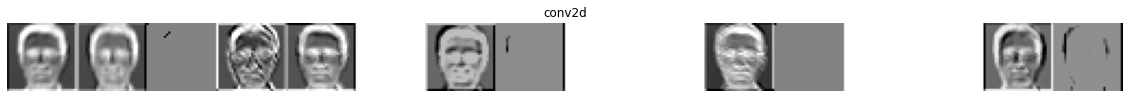

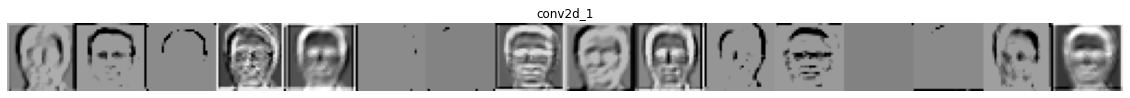

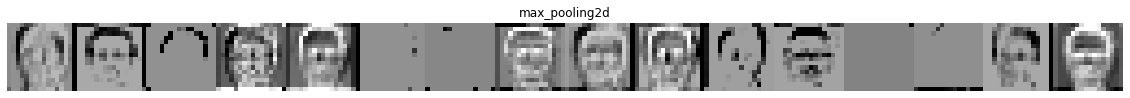

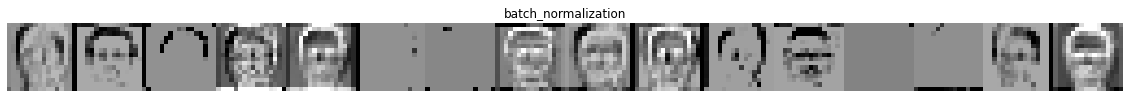

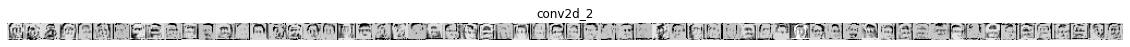

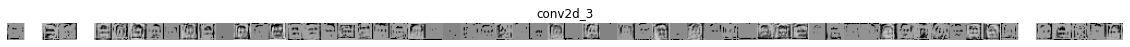

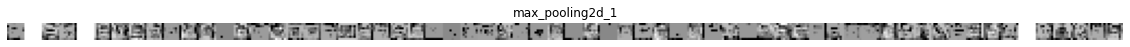

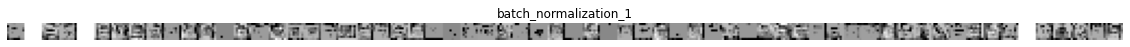

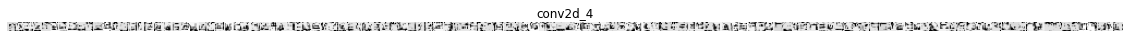

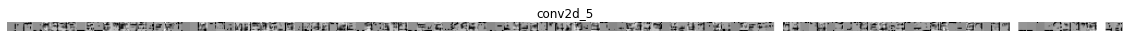

In [35]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
layer_names = [layer.name for layer in model.layers]
layer_outputs = [layer.output for layer in model.layers]
feature_map_model = tf.keras.models.Model(model.input, layer_outputs)

successive_feature_maps = feature_map_model.predict(test_dataset, batch_size=BATCH_SIZE)
# Retrieve are the names of the layers, so can have them as part of our plot
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  #print(feature_map.shape)
  if len(feature_map.shape) == 4:
    
    # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
   
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    # Postprocess the feature to be visually palatable
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      # Tile each filter into a horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
# Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.axis ('off')
    plt.imshow( display_grid, aspect='auto', cmap='binary' )

# Bonus \#2: Use your webcam

## Camera capture code snippet from Google Colab 

In [36]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.png', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/png', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [37]:
import PIL.Image
import numpy as np
from skimage import transform
def predict_img(filename):
  image = PIL.Image.open(filename).convert('RGB')
  image = np.array(image).astype('float32')/255
  image = transform.resize(image, (64, 64, 3))
  image = np.expand_dims(image, axis=0)
  pred = model.predict(image, batch_size=1)
  if pred > 0.5:
    return 'You have glasses!', pred
  else: 
    return 'You have no glasses!', pred

## Let's test it

<IPython.core.display.Javascript object>

Saved to photo.png


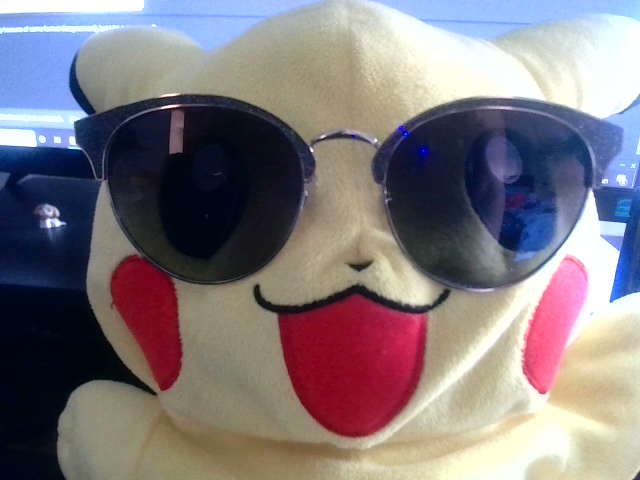

('You have glasses!', array([[0.9260598]], dtype=float32))


In [39]:
from IPython.display import Image

def take_a_picture():
  try:
    filename = take_photo()
    print('Saved to {}'.format(filename))
    # Show the image which was just taken.
    display(Image(filename))
    print(predict_img(filename))
    
  except Exception as err:
    # Errors will be thrown if the user does not have a webcam or if they do not
    # grant the page permission to access it.
    print(str(err))

take_a_picture()

It doesn't perform very well (probably because of some format disagreement), but I think it's cool. 😄